In [1]:
import numpy as np
from chipthicknesswithrunout2    import chipthicknesswithrunout
import pymc3
import matplotlib.pyplot as plt
from pymc3 import  *
import arviz
import theano
import theano.tensor as tt




# One second of fake data is created. 
Even though not sure if it is 1 sec, the explanation is:
In "E. Gozu, Y. Karpat, “Uncertainty analysis of force coefficients during micromilling of titanium alloy” article, it is noted that : Force signals were acquired with 10^5 data points per second during the experiments. 

There are 28,000 revolution per minutes, thus, 28000/60 = 466.6 revolutions per second.
10^5/ 467 = 214, Means that we need 214 data point per revolution.
Total step is then = 214 point/rev * 466 rev = 99724. 



# Fake Data is Created with   
    Kte = 8.4
    Ktestd = 1.2
    Ktc = 4477
    Ktcstd = 276
    Kre = 13.4
    Krestd =  1.2
    Krc = 2849
    Krcstd = 286
    ## Each one is normally distributed.
    These parameters are the optimized parameters of E. Gozu, Y. Karpat, “Uncertainty analysis of force coefficients during micromilling of titanium alloy”. The analytical formula is randomized by these parameters. 
# Experimental parameters are as follows:
    b = 0.030
    ft = 0.001
    gamma = 30       
    d = 0.4 #; % cutter diameter, mm
    Nt = 2    #; % numberofteeth
    omega =  28000  #  28000; % spindle speed, rpm
    # Toolrunoutspecs
    ro = 0 #; % radyusofrun - out, mm
    gama = 100 * np.pi / 180 #; % angleof run - out, rad
    r0 = 0.2 = (d / 2)
    r1 = 0.2 = (d / 2)


In [2]:
x = np.load("x.npy")
y = np.load("y.npy")
Force_x_obs = np.load("Force_x.npy")
Force_y_obs = np.load("Force_y.npy")

# Data Visualisation

(642,)


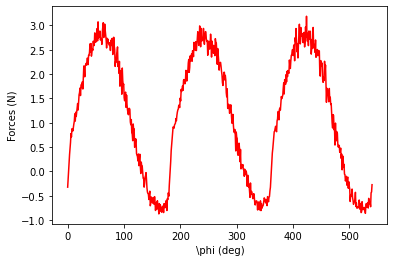

In [3]:
plt.plot(x, Force_x_obs, 'r')#, phi * 180 / np.pi, Force_y, 'g', 'LineWidth', 2)                  
#plt.plot(phi * 180 / np.pi, Force_x )                                                                        
                                                                                                              
#set(gca, 'FontSize', 14)                                                                                     
axes = plt.gca()                                                                                              
print(np.shape(Force_x_obs))                                                                                      
                                                          
#axes.set_ylim(0,np.shape(Force_y)[0])                                                                        
plt.xlabel('\phi (deg)')                                                                                      
plt.ylabel('Forces (N)')                                                                                      
plt.show()                                                                                                    
        #avFx = np.mean(Force_x);      

One Full Turn on the same dataset, 360 degrees

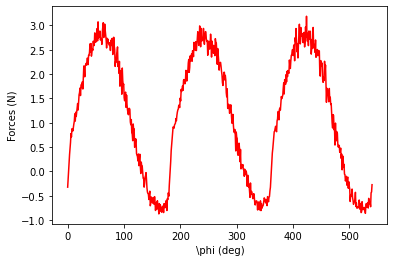

In [4]:
plt.plot(x[:720], Force_x_obs[:720], 'r')
plt.xlabel('\phi (deg)')                                                                                      
plt.ylabel('Forces (N)')                                                                                      
plt.show()   

Defining Time Varying Parameters of Experiments: phi,phix,phis, Ap, Aj.  steps,duration is not varied by time predefined during experiment.

Since they're predefined in real force data, we're just determining the values of h, phi and other variables that changes through time. They're not calculated during Bayesian Opt.


In [5]:
steps =  np.shape(Force_x_obs)[0]
durationstep = int(np.shape(Force_x_obs)[0] / 214)
duration = durationstep * np.pi
phi = np.linspace(0, duration, steps)
dphi = duration / steps


istep = range(steps)

ro = 0

b = 0.050
                                              
ft = 0.009                                  
gamma = 21

d = 0.4 #; % cutter diameter, mm
Nt = 2    #; % numberofteeth
r0 = (d / 2)
r1 = (d / 2)

L0 = r0
L1 = r1
                                              
d = 0.4 #; % cutter diameter, mm              
Nt = 2    #; % numberofteeth                  
omega =  28000  #  28000; % spindle speed, rpm 
if gamma == 0: #% straight teeth                              
    db = b    #; % discretizedaxialdepth, m                   
else:  # % nonzerohelix angle                                 
    db = d * (dphi) / 2 / np.tan(gamma * np.pi / 180) 
    
print(db)

steps_axial = round(b / db) #  number ofstepsalongtoolaxis
kappa = db * np.tan(gamma * np.pi / 180) / (d / 2)    
gama = 100 * np.pi / 180
            
steps_axial = round(b / db)                          
q = ft/np.pi
phix = phi -(steps_axial-1)*kappa
tetap = phix

phis = phix-np.pi
tetas = phis

xp = ro * np.sin(tetap + gama) + q * tetap
yp = ro * np.cos(tetap + gama)
xs = ro * np.sin(tetas + gama) + q * tetas
ys = ro * np.cos(tetas + gama)
alfa = np.arctan((ys - yp) / (xs - xp))

fc = np.sqrt((xp - xs) ** 2 + (yp - ys) ** 2)

h0 = L0 + fc * np.sin(tetap + alfa) - np.sqrt(L0 ** 2 - (fc ** 2) * (np.cos(tetap + alfa)) ** 2)
h1 = L1 + fc * np.sin(tetap - np.pi + alfa) - np.sqrt(L1 ** 2 - (fc ** 2) * (np.cos(tetap - np.pi + alfa)) ** 2)

0.00764871838092


There are 159 elements that doesn't hold (h0[i]>=0 and h1[i]<0)  (h0[i]<0 and h1[i]>=0) these conditions
We will be assuming that they're belong to h0. # Not analysed how true is it, but there are 100000 elements in Force, it seems it is negligible. 
We'll assume they are belonging to (h0[i]>=0 and h1[i]<0) condition

In [6]:
print(((h0[0]>=0) and (h1[0]<0))*1 + ((h0[0]<0) and (h1[0]>=0))*1 ,"--")
check2 = 0
check0 = 0


for i in range(len(h0)):
    check2 += (((h0[i]>=0 and h1[i]<0)*1 + (h0[i]<0 and h1[i]>=0)*1) == 2)*1
    check0 += (((h0[i]>=0 and h1[i]<0)*1 + (h0[i]<0 and h1[i]>=0)*1) == 0)*1
print(check2,"Does hold both condition")
print(check0,"Doesnt hold both condition")




1 --
0 Does hold both condition
9 Doesnt hold both condition


In [7]:
hwithoutif = np.array([])
phiwithoutif = np.array([])
for i in range(len(h0)):
    
    if h0[i]>=0 and h1[i]<0: #+ (h0[i]<0 and h1[i]>=0)*1
        hwithoutif = np.append(hwithoutif,h0[i])
        phiwithoutif = np.append(phiwithoutif,phix[i])
    elif h1[i] >=0  and h0[i] < 0:
        hwithoutif = np.append(hwithoutif,h1[i])
        phiwithoutif = np.append(phiwithoutif,phis[i])
    else:
        hwithoutif = np.append(hwithoutif,h0[i])
        phiwithoutif = np.append(phiwithoutif,phix[i])
"""
print(h1.shape)
print(hwithoutif.shape)
print(h1[:20])
print(h0[:20])
print(hwithoutif[:20])
"""

'\nprint(h1.shape)\nprint(hwithoutif.shape)\nprint(h1[:20])\nprint(h0[:20])\nprint(hwithoutif[:20])\n'

Defining Priors as it's indicated at ( https://link.springer.com/article/10.1007/s00170-017-0567-8 ) article.

In [8]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    Kte = Normal('Kte', 9.1, sigma=3)
    Ktc = Normal('Ktc', 4475, sigma=300)
    Kre = Normal('Kre', 13.2, sigma=3)
    Krc = Normal('Krc', 2854, sigma=300)
    #Ktp = Normal('Ktp', 13623, sigma=1400)
    #Krp = Normal('Krp', 4307, sigma=400)


In [9]:
def hphi(ro,b,ft,d,gamma,lenofobsForce):      


        steps = int(lenofobsForce)
        
        
        ro = 0 
        r0 = (d / 2) #;
        r1 = (d / 2) #;
        L0 = r0
        L1 = r1              

        durationstep = int(steps/214)
        duration = durationstep * np.pi       #; % 3full rotation
        phi = np.linspace(0, duration, steps);
    #steps = 360 * 1
        dphi = duration / steps
        print(dphi,"dphi")
        print(b,"b")
        if gamma == 0: #% straight teeth
            db = b    #; % discretizedaxialdepth, m
        else:  # % nonzerohelix angle
            db = d * (dphi) / 2 / np.tan(gamma * np.pi / 180)
        
        
        kappa = db * np.tan(gamma * np.pi / 180) / (d / 2)
        print(db,"db")
        steps_axial = int(round(b / db))
        
        print(steps_axial)
        harray = np.zeros(int(steps*steps_axial))
        #h0array = np.zeros(steps)
        #h1array = np.zeros(steps)
        print(steps_axial,"stepsax")
        phiarray = np.zeros(int(steps*steps_axial))
        
        for i in range(int(steps)):

            
            for cnt4 in range(steps_axial):

                q = ft / np.pi
                
                phix = phi[i] - (cnt4 - 1) * kappa
                
                phis = phix - np.pi

                xp = ro * np.sin(phix + gama) + q * phix
                yp = ro * np.cos(phix + gama)
                xs = ro * np.sin(phis + gama) + q * phis
                ys = ro * np.cos(phis + gama)
                alfa = np.arctan((ys - yp) / (xs - xp))
                fc = np.sqrt((xp - xs) ** 2 + (yp - ys) ** 2)

                h0 = L0 + fc * np.sin(phix + alfa) - np.sqrt(L0 ** 2 - (fc ** 2) * (np.cos(phix + alfa)) ** 2)
                h1 = L1 + fc * np.sin(phix - np.pi + alfa) - np.sqrt(L1 ** 2 - (fc ** 2) * (np.cos(phix - np.pi + alfa)) ** 2)
                
                
   

                if h0 >= 0 and h1 < 0:
                    #Ft = db * h0 * Ktc + db * Kte
                    #Fn = db * h0 * Krc + db * Kre
                    harray[i*steps_axial+cnt4] = h0
                    phiarray[i*steps_axial+cnt4] = phix
                elif h1 >=0  and h0 < 0:

                    #Ft = db * h1 * Ktc + db * Kte
                    #Fn = db * h1 * Krc + db * Kre
                    
                    harray[i*steps_axial+cnt4] = h1
                    phiarray[i*steps_axial+cnt4] = phis
                    
        return harray,phiarray,steps_axial
    


Probably, there's an error at determining h, phi and other values. Parameters found after optimization seems away from the ones that you've found. 

Probably, while calculating F's, phis are calculated three times. I applied some trick to calculate phis, it may yield a problem.



First of all, I would like to use all the data points to calculate Kte, Ktc, Kre, Krc models. Then, I'll take every 10th element of the Force data, and will analyse optimized K values are similar to each other. I would like to do it in a manner of shortening the time of calculating optimised parameters, if necessary. 

Using NUTS sampler.

In [10]:


k = 1


Forcelen = np.shape(Force_x_obs)[0]
elements = np.arange(1,Forcelen,k)



h, phi, steps_axial = hphi(ro,b,ft,d,gamma,Forcelen)
print(len(h),"lenh")
print(Forcelen,"forcelen")
print(len(phi),"phi")

"""    print(arr.get_value(borrow=True).shape)
    arr = arr.reshape((arr.shape.eval()/steps_axial,steps_axial))
    print(arr.sum(axis=2)) arr.flatten"""
def sumeveryaxial(arr,steps_axial,Forcelen):

    arr = arr.reshape((-1,steps_axial))
    arr = arr.sum(axis=1) 
    return arr.flatten()
  
    


with model:
    
    Ft = (Kte+Ktc*h)*db
    Fr = (Kre+Krc*h)*db
 
    print(len(h),"len h")
    print(len(Force_x_obs),"orig forcelen h")    
    print(Forcelen,"forcelen")   
    print(steps_axial,"steps axial")
    Fx = Normal('likelihood_1', mu = sumeveryaxial(Ft*np.cos(phi)+Fr*np.sin(phi),steps_axial,Forcelen), observed=Force_x_obs)
    Fy = Normal('likelihood_2', mu = sumeveryaxial(Ft*np.sin(phi)-Fr*np.cos(phi),steps_axial,Forcelen), observed=Force_y_obs)# % N    
    trace = pymc3.sample(step=pymc3.Metropolis())

pymc3.summary(trace)
 

#plot_posterior_predictive_glm(trace)


0.014680339502756042 dphi
0.05 b
0.00764871838092 db
7
7 stepsax
4494 lenh
642 forcelen
4494 phi
4494 len h
642 orig forcelen h
642 forcelen
7 steps axial


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [Krc]
>Metropolis: [Kre]
>Metropolis: [Ktc]
>Metropolis: [Kte]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1117.28draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Kte,8.894233,1.182071,0.100781,6.813937,11.427227,29.646892,0.999000
Ktc,4399.046615,173.705237,15.403146,4050.007577,4716.196920,25.839145,0.999056
Kre,13.437750,1.347638,0.120556,11.097996,16.026640,21.059603,1.089698
Krc,2828.582736,197.547993,17.721796,2473.757265,3204.396560,20.885171,1.085413


It takes 02:23 secs with all the data points. It seems that results are not very far away from the parameters that you optimize in ( https://link.springer.com/article/10.1007/s00170-017-0567-8 ) paper.


    Kte = 8.4
    Ktestd = 1.2
    Ktc = 4477
    Ktcstd = 276
    Kre = 13.4
    Krestd =  1.2
    Krc = 2849
    Krcstd = 286

In [20]:
#pymc3.plots.traceplot(trace,combined = False)
pandastrace =pymc3.summary(trace)
pandastrace.loc["Krc", "mean"]

2828.582736023799

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114c01fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114d64e10>]], dtype=object)

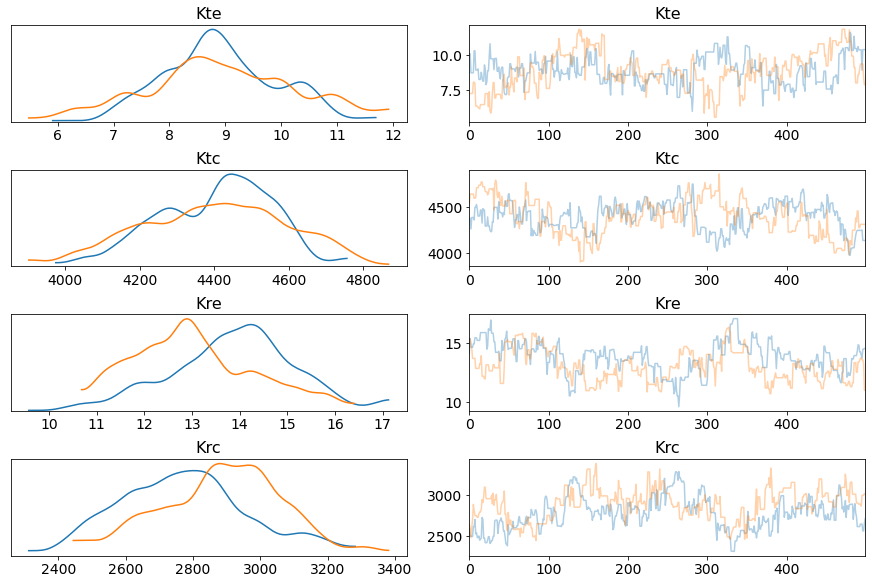

In [12]:
pymc3.plots.traceplot(trace,combined = False)

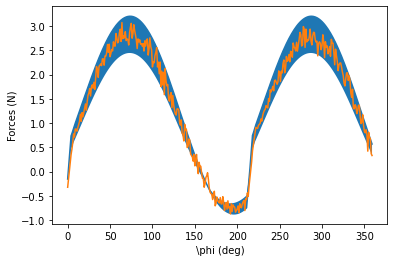

In [13]:

Ftup = (pandastrace.loc["Kte", "hpd_97.5"] + pandastrace.loc["Ktc", "hpd_97.5"] * h[0:360*steps_axial]) * db
Frup = (pandastrace.loc["Kre", "hpd_97.5"] + pandastrace.loc["Krc", "hpd_97.5"] * h[0:360*steps_axial]) * db

Ftbot = (pandastrace.loc["Kte", "hpd_2.5"] + pandastrace.loc["Ktc", "hpd_2.5"] * h[0:360*steps_axial]) * db
Frbot = (pandastrace.loc["Kre", "hpd_2.5"] + pandastrace.loc["Krc", "hpd_2.5"] * h[0:360*steps_axial]) * db

Ft = (pandastrace.loc["Kte", "mean"] + pandastrace.loc["Ktc", "mean"] * h[0:360*steps_axial]) * db
Fr = (pandastrace.loc["Kre", "mean"] + pandastrace.loc["Krc", "mean"] * h[0:360*steps_axial]) * db

Fxm = Ft * np.cos(phi[0:360*steps_axial]) + Fr * np.sin(phi[0:360*steps_axial])
Fxup = Ftup * np.cos(phi[0:360*steps_axial]) + Frup * np.sin(phi[0:360*steps_axial])
Fxdown = Ftbot * np.cos(phi[0:360*steps_axial]) + Frbot * np.sin(phi[0:360*steps_axial])

Fxup = np.add.reduceat(Fxup, np.arange(0, len(Fxup), steps_axial))
Fxdown = np.add.reduceat(Fxdown, np.arange(0, len(Fxdown), steps_axial))
plt.plot(Fxup)
plt.plot(Force_x_obs[0:360])


plt.fill_between(np.arange(360), Fxup, Fxdown)

plt.xlabel('\phi (deg)')                                                                                      
plt.ylabel('Forces (N)')                 
plt.show()

Switch to Metropolis Hasting Sampling 

In [14]:

with Model() as modelMetro: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    Kte = Normal('Kte', 9.1, sigma=3)
    Ktc = Normal('Ktc', 4475, sigma=300)
    Kre = Normal('Kre', 13.2, sigma=3)
    Krc = Normal('Krc', 2854, sigma=300)
    #Ktp = Normal('Ktp', 13623, sigma=1400)
    #Krp = Normal('Krp', 4307, sigma=400)

k = 1

elements = np.arange(1,np.shape(Force_x_obs)[0],k)
    
    
with modelMetro:
    Ft = (Kte+Ktc*hwithoutif[elements])*db
    Fr = (Kre+Krc*hwithoutif[elements])*db
    
    Fx = Normal('likelihood_1', mu = Ft*np.cos(phiwithoutif[elements])+Fr*np.sin(phiwithoutif[elements]), observed=Force_x_obs[elements])
    Fy = Normal('likelihood_2', mu = Ft*np.sin(phiwithoutif[elements])- Fr*np.cos(phiwithoutif[elements]),observed=Force_y_obs[elements])# % N    
    traceMetro = pymc3.sample(step=pymc3.Metropolis())

pymc3.summary(trace)
 

plt.figure(figsize=(5, 5))
#plot_posterior_predictive_glm(trace)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [Krc]
>Metropolis: [Kre]
>Metropolis: [Ktc]
>Metropolis: [Kte]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1455.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

Compared to NUTS, very fast, 19 secs.

In [15]:
pymc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Kte,8.894233,1.182071,0.100781,6.813937,11.427227,29.646892,0.999000
Ktc,4399.046615,173.705237,15.403146,4050.007577,4716.196920,25.839145,0.999056
Kre,13.437750,1.347638,0.120556,11.097996,16.026640,21.059603,1.089698
Krc,2828.582736,197.547993,17.721796,2473.757265,3204.396560,20.885171,1.085413


In [16]:
pymc3.summary(traceMetro)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Kte,57.841016,2.423065,0.141217,52.888950,62.372134,251.215989,0.999385
Ktc,8010.780519,288.156026,24.429697,7486.660839,8613.457835,65.629010,0.999558
Kre,50.388439,2.594428,0.166716,45.131825,55.445754,143.681954,1.002068
Krc,5374.754914,289.067005,25.018648,4908.264153,6018.207620,55.483784,1.030090


Now I would like to take every 5th element of the force data, and observe how long does it take, how K's far away.

In [17]:

with Model() as modelMetroSmall: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    Kte = Normal('Kte', 9.1, sigma=3)
    Ktc = Normal('Ktc', 4475, sigma=300)
    Kre = Normal('Kre', 13.2, sigma=3)
    Krc = Normal('Krc', 2854, sigma=300)
    #Ktp = Normal('Ktp', 13623, sigma=1400)
    #Krp = Normal('Krp', 4307, sigma=400)

k = 5 # Take only every 5th element

elements = np.arange(1,np.shape(Force_x_obs)[0],k)
    
    
with modelMetroSmall:
    Ft = (Kte+Ktc*hwithoutif[elements])*db
    Fr = (Kre+Krc*hwithoutif[elements])*db
    
    Fx = Normal('likelihood_1', mu = Ft*np.cos(phiwithoutif[elements])+Fr*np.sin(phiwithoutif[elements]), observed=Force_x_obs[elements])
    Fy = Normal('likelihood_2', mu = Ft*np.sin(phiwithoutif[elements])- Fr*np.cos(phiwithoutif[elements]),observed=Force_y_obs[elements])# % N    
    traceMetroSmall = pymc3.sample(step=pymc3.Metropolis())




Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [Krc]
>Metropolis: [Kre]
>Metropolis: [Ktc]
>Metropolis: [Kte]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1199.13draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
pymc3.summary(traceMetroSmall)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Kte,22.387855,2.937203,0.166508,17.081921,27.964856,232.533928,0.999375
Ktc,5429.752582,282.845501,17.342422,4941.928412,6013.890453,233.028847,0.999812
Kre,22.992951,3.027201,0.182887,16.935654,28.286691,188.279795,0.999785
Krc,3530.903307,296.199505,18.744705,2902.855459,4044.235096,191.512602,0.999010


Fast, but not so similar with results above.


In [19]:
pymc3.summary(traceMetro) # Old one 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Kte,57.841016,2.423065,0.141217,52.888950,62.372134,251.215989,0.999385
Ktc,8010.780519,288.156026,24.429697,7486.660839,8613.457835,65.629010,0.999558
Kre,50.388439,2.594428,0.166716,45.131825,55.445754,143.681954,1.002068
Krc,5374.754914,289.067005,25.018648,4908.264153,6018.207620,55.483784,1.030090
